In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from keras.layers import *
from keras.models import Model
import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.losses import categorical_crossentropy
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_prep
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

In [2]:
df=pd.read_csv('../input/100-bird-species/birds.csv',dtype=str)
app="../input/100-bird-species/"
for index,row in tqdm(df.iterrows()):
    row['filepaths']=app+row['filepaths']

62388it [00:03, 18557.52it/s]


In [3]:
# Training Data generator
train_df=df.loc[df['data set']=='train']
train_df1=train_df[['filepaths','labels']]
train_df1.rename(columns = {'filepaths':'filename','labels':'class'}, inplace = True)
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,width_shift_range=[0.5,1.5],height_shift_range=[0.5,1.5],
                              rotation_range=45,brightness_range=[0.5,1.5],horizontal_flip=True,shear_range=45,zoom_range=[0.5,1.5],preprocessing_function=vgg19_prep)
train_gen = ImageFlow.flow_from_dataframe(dataframe=train_df1,target_size=(224,224),seed=10,batch_size=512)

Found 58388 validated image filenames belonging to 400 classes.


**Loading the trained model**

In [4]:
model=keras.models.load_model('../input/bestvgg/bestvgg19.h5')

2022-06-23 06:49:01.088836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 06:49:01.252335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 06:49:01.253278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 06:49:01.254724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Getting the class labels using train generator**

In [5]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

**Taking a sample image and performing error analysis on it<br>
First we will predict the top 5 probable classes the image belongs to**

2022-06-23 06:49:06.478161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-23 06:49:07.561811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


ACtual Species is :ABBOTTS BABBLER and top 5 species & the probabilities according to model
 FAIRY BLUEBIRD:1.0
 YELLOW HEADED BLACKBIRD:0.0
 CRESTED OROPENDOLA:0.0
 CRAB PLOVER:0.0
 CRANE HAWK:0.0


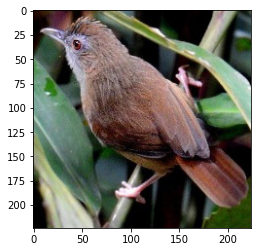

In [6]:
image = tf.keras.utils.load_img('../input/100-bird-species/test/ABBOTTS BABBLER/1.jpg',target_size=(224,224)) 
img = tf.keras.utils.img_to_array(image)
img = np.expand_dims(img, axis=0) 
prediction = model.predict(img)
sorted_preds = np.sort(prediction)[0][::-1]
top5 = np.argsort(prediction)[0][::-1][:5]
print('\033[1m' +"ACtual Species is :ABBOTTS BABBLER and top 5 species & the probabilities according to model")
for i in range(len(top5)):
    pred_species = labels.get(top5[i])
    text = pred_species + ":" + str(sorted_preds[i])
    print('\033[1m' ,text)
plt.imshow(image)


**Actual Species is ABBOTTS BABBLER and the highest probable species according to model is Fairy Bluebird <br>
Let us inspect why model is giving the above result**

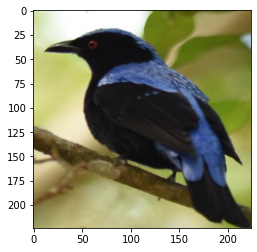

In [7]:
#Display sample image belonging to Fairy Bluebird species
image1 = tf.keras.utils.load_img('../input/100-bird-species/test/FAIRY BLUEBIRD/1.jpg',target_size=(224,224)) 
plt.imshow(image1)

**Reference URL: https://colab.research.google.com/github/arteagac/arteagac.github.io/blob/master/blog/lime_image.ipynb#scrollTo=eF3nyAc2i-Nt**

**Extract super pixels from image**

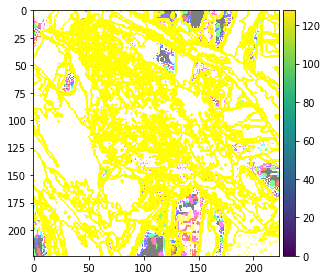

In [8]:
image = tf.keras.utils.load_img('../input/100-bird-species/test/ABBOTTS BABBLER/1.jpg',target_size=(224,224)) 
img = tf.keras.utils.img_to_array(image)
superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))

In [9]:
# Creating random perturbations
num_perturb = 200
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))


In [10]:
# function for generating pertubed_image
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

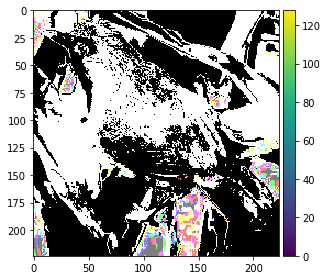

In [11]:
pert_image=perturb_image(img/2+0.5,perturbations[0],superpixels)
skimage.io.imshow(pert_image)

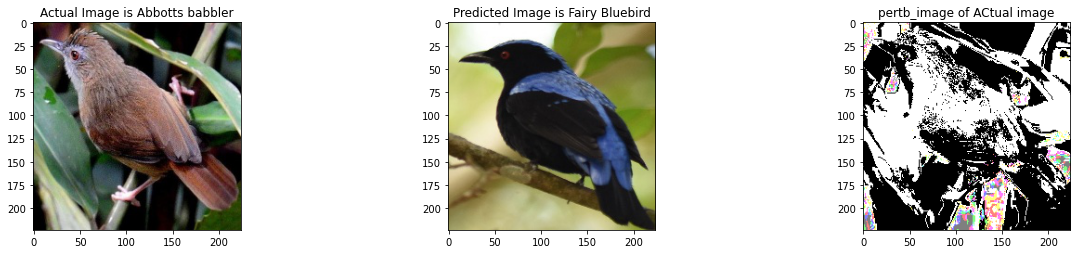

In [12]:
count=1
plt.subplots(figsize=(18,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.4)
plt.subplot(1,3,1)
plt.title('Actual Image is Abbotts babbler')
plt.imshow(image)
plt.subplot(1,3,2)
plt.title('Predicted Image is Fairy Bluebird')
plt.imshow(image1)
plt.subplot(1,3,3)
plt.title('pertb_image of ACtual image')
plt.imshow(pert_image)

**As the pertb_image is similar to fairy blue bird, model is predicting it as fairy bluebird**